In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

import clmm
import numpy as np
from numpy import random
from clmm import Cosmology
from clmm.support import mock_data as mock
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rc('text', usetex=True)

In [2]:
# np.random.seed(0)
# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
sigma_g       = 5e-2  # True ellipticity standard variation
sigma_z       = 5e-2
ndata         = 1000

r_lim  = [0.60, 3.2]
z_lim  = [0.41, 4.1]
zp_lim = [0.40, 4.1]

# Create Galaxy WL Likelihood object
# gsdp  = Nc.GalaxySDPositionFlat ()
gsdp  = Nc.GalaxySDPositionSRDY1 ()
gsdzp = Nc.GalaxySDZProxyGauss ()
gsds  = Nc.GalaxySDShapeGauss ()

gsdp.set_z_lim (Ncm.Vector.new_array (z_lim))
gsdp.set_r_lim (Ncm.Vector.new_array (z_lim))
gsdzp.set_z_lim (Ncm.Vector.new_array (zp_lim))
gsdzp.set_sigma (sigma_z)
gsds.set_sigma (sigma_g)

gwll = Nc.GalaxyWLLikelihood (s_dist=gsds, zp_dist=gsdzp, rz_dist=gsdp)
gwll.set_ndata (ndata)

moo = clmm.Modeling (massdef='mean', delta_mdef=200, halo_profile_model='nfw')
moo.set_cosmo(cosmo)
mset = moo.get_mset ()

data = mock.generate_galaxy_catalog (cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=sigma_g, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec, photoz_sigma_unscaled=sigma_z)
gc   = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
gc.compute_tangential_and_cross_components(geometry="flat")

radius = clmm.convert_units (gc.galcat['theta'], "radians", "Mpc", redshift = cluster_z, cosmo = cosmo)
r_mean = np.mean (radius)
g_mean = np.mean (gc.galcat['et'])
z_mean = np.mean (gc.galcat['z'])

from matplotlib.animation import FuncAnimation

cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoLCDM")
dp = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.CRITICAL, 200)
dist = Nc.Distance.new (4.0)
dist.prepare (cosmo)
smd = Nc.WLSurfaceMassDensity.new (dist)
gwll.prepare (cosmo, dp, smd, 0.4)

kde = gwll.peek_kde ()

r_x = np.linspace (r_lim[0], r_lim[1], 1000)
z_x = np.linspace (z_lim[0], z_lim[1], 1000)
g_x = np.linspace (min (gc.galcat['et']), max (gc.galcat['et']), 1000)

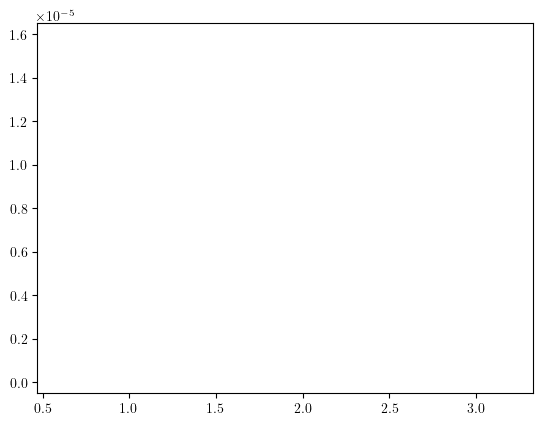

In [3]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
z_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    z_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(z):
    p_r = []
    for i in range (len(r_x)):
        x = Ncm.Vector.new_array ([r_x[i], z, g_mean])
        p_r.append (kde.eval (x))
    line.set_data(r_x, p_r)
    z_text.set_text (f'z = {z}')
    g_text.set_text (f'g = {g_mean}')
    axis.relim (); axis.autoscale_view ()
    return line, z_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = z_x, interval = 20, blit = False)
anim.save('r_kde_(varying_z)(1000).mp4', writer = 'ffmpeg', fps = 30)

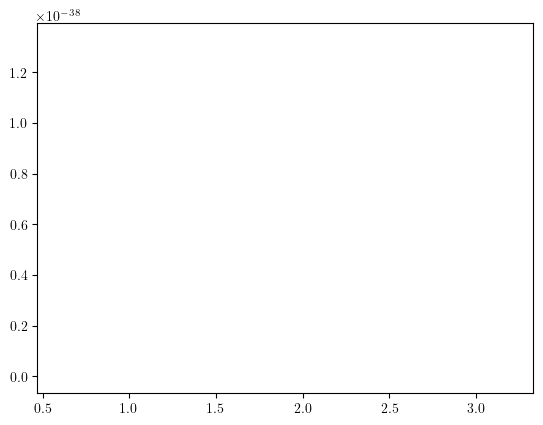

In [4]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
z_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    z_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(g):
    p_r = []
    for i in range (len(r_x)):
        x = Ncm.Vector.new_array ([r_x[i], z_mean, g])
        p_r.append (kde.eval (x))
    line.set_data(r_x, p_r)
    z_text.set_text (f'z = {z_mean}')
    g_text.set_text (f'g = {g}')
    axis.relim (); axis.autoscale_view ()
    return line, z_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = g_x, interval = 20, blit = False)
anim.save('r_kde_(varying_g)(1000).mp4', writer = 'ffmpeg', fps = 30)

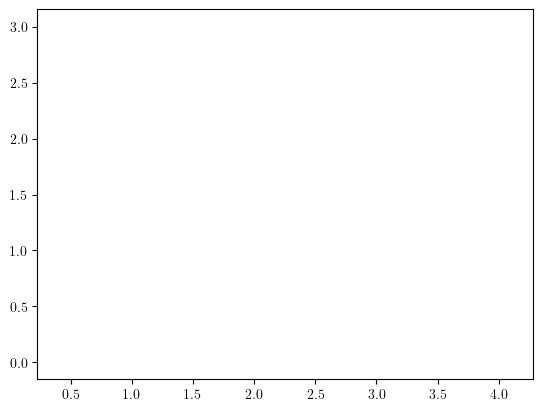

In [5]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(r):
    p_z = []
    for i in range (len(z_x)):
        x = Ncm.Vector.new_array ([r, z_x[i], g_mean])
        p_z.append (kde.eval (x))
    line.set_data(z_x, p_z)
    r_text.set_text (f'r = {r}')
    g_text.set_text (f'g = {g_mean}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = r_x, interval = 20, blit = False)
anim.save('z_kde_(varying_r)(1000).mp4', writer = 'ffmpeg', fps = 30)

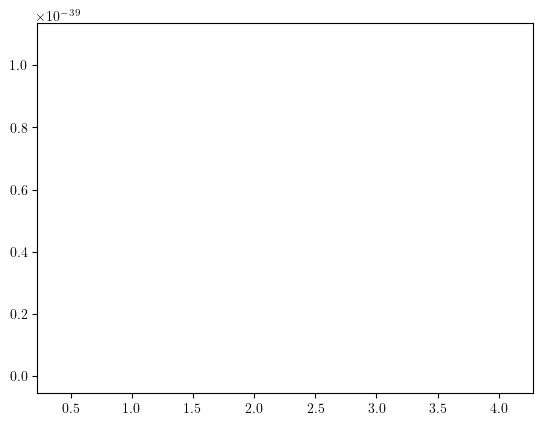

In [6]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
g_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    g_text.set_text ('')
    return line,

def animate(g):
    p_z = []
    for i in range (len(z_x)):
        x = Ncm.Vector.new_array ([r_mean, z_x[i], g])
        p_z.append (kde.eval (x))
    line.set_data(z_x, p_z)
    r_text.set_text (f'r = {r_mean}')
    g_text.set_text (f'g = {g}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, g_text

anim = FuncAnimation(fig, animate, init_func = init, frames = g_x, interval = 20, blit = False)
anim.save('z_kde_(varying_g)(1000).mp4', writer = 'ffmpeg', fps = 30)

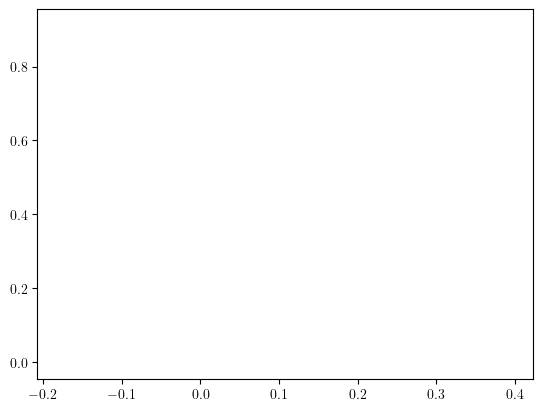

In [7]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
z_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    z_text.set_text ('')
    return line,

def animate(r):
    p_g = []
    for i in range (len(g_x)):
        x = Ncm.Vector.new_array ([r, z_mean, g_x[i]])
        p_g.append (kde.eval (x))
    line.set_data(g_x, p_g)
    r_text.set_text (f'r = {r}')
    z_text.set_text (f'z = {z_mean}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, z_text

anim = FuncAnimation(fig, animate, init_func = init, frames = r_x, interval = 20, blit = False)
anim.save('g_kde_(varying_r)(1000).mp4', writer = 'ffmpeg', fps = 30)

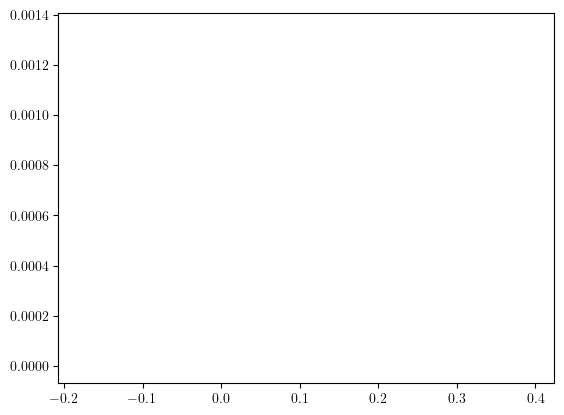

In [8]:
fig = plt.figure ()
axis = plt.axes ()
line, = axis.plot([], [], lw = 3)
r_text = axis.text (0.02, 0.95, '', transform=axis.transAxes)
z_text = axis.text (0.02, 0.90, '', transform=axis.transAxes)

def init(): 
    line.set_data([], [])
    r_text.set_text ('')
    z_text.set_text ('')
    return line,

def animate(z):
    p_g = []
    for i in range (len(g_x)):
        x = Ncm.Vector.new_array ([r_mean, z, g_x[i]])
        p_g.append (kde.eval (x))
    line.set_data(g_x, p_g)
    r_text.set_text (f'r = {r_mean}')
    z_text.set_text (f'z = {z}')
    axis.relim (); axis.autoscale_view ()
    return line, r_text, z_text

anim = FuncAnimation(fig, animate, init_func = init, frames = z_x, interval = 20, blit = False)
anim.save('g_kde_(varying_z)(1000).mp4', writer = 'ffmpeg', fps = 30)